In [1]:
# Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import numpy as np
import tensorflow as tf
import random as python_random

def reset_seeds(SEED = 624):
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

tf.config.experimental.enable_op_determinism()

# Price Volume data retrieval using Yahoo Finance API

Target tickers:
- S&P 500 Index (SPY)
- VIX Index (^VIX)
- Gold (GC=F)
- Brent Crude (BZ=F)
- WTI (CL=F)

In [2]:
import yfinance as yf
import talib

In [3]:
# Create price extractor

class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        self.lp, self.ret = self.__get_daily_returns__()
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
symbols = ["SPY", "^VIX", "GC=F", "BZ=F", "CL=F"]

data = price_volume_data(symbols, '2013-01-01', '2023-05-25')

C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Close_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


# Data Visualization

In [5]:
data.get_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2618 entries, 2012-12-31 to 2023-05-24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2618 non-null   float64
 1   High          2618 non-null   float64
 2   Low           2618 non-null   float64
 3   Close         2618 non-null   float64
 4   Volume        2618 non-null   int64  
 5   Dividends     2618 non-null   float64
 6   Stock Splits  2618 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 228.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2618 entries, 2012-12-31 to 2023-05-24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2618 non-null   float64
 1   High          2618 non-null   float64
 2   Low           2618 non-null   float64
 3   Close         2618 non-null   float64
 4   Volume        2618 non-null   int64  
 5   Dividen

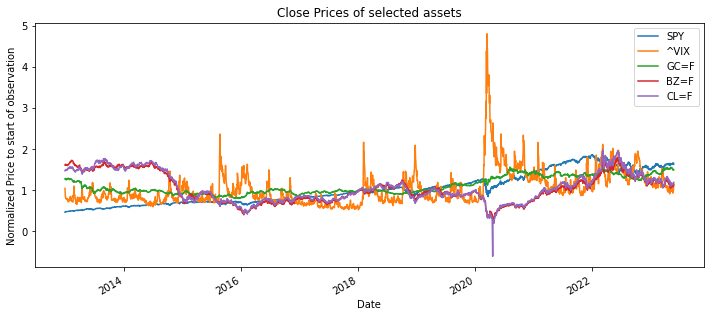

In [6]:
data.plot_price_trends(reference = 0)

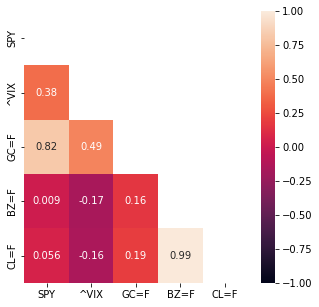

In [7]:
data.plot_corr()

# Generate technical indicators

In [8]:
data.get_technical_indicators()
data.pv['CL=F'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_5,SMA_14,ATR_5,ATR_14,ADX_5,ADX_14,RSI_5,RSI_14,MACD,MACD_signal,BBANDS_upp,BBANDS_mid,BBANDS_low
Date,,,,,,,,,,,,,,,,,,,,
2023-05-18,72.750000,72.870003,71.419998,71.860001,80864,0,0,71.340001,71.630001,2.334759,2.589797,26.485585,24.932016,49.730616,44.982792,-1.394847,-1.386904,73.229721,71.340001,69.450281
2023-05-19,71.940002,73.400002,71.029999,71.550003,69949,0,0,71.642001,71.336429,2.341808,2.574098,23.747167,24.350027,46.789674,44.216580,-1.342506,-1.378025,73.016594,71.642001,70.267408
2023-05-22,71.699997,72.360001,70.550003,71.989998,263977,0,0,71.818001,71.360000,2.235446,2.519519,19.563407,24.010455,51.842410,45.632110,-1.251100,-1.352640,73.097088,71.818001,70.538914
2023-05-23,72.099998,73.790001,71.709999,72.910004,317586,0,0,72.228001,71.667858,2.204357,2.488125,22.082936,22.859615,61.418052,48.570786,-1.091837,-1.300479,73.315856,72.228001,71.140147
2023-05-24,73.769997,74.730003,73.129997,74.339996,386611,0,0,72.530000,72.080715,2.127486,2.440402,27.063144,21.291910,72.169687,52.837864,-0.840542,-1.208492,74.554132,72.530000,70.505869


<AxesSubplot:xlabel='Date'>

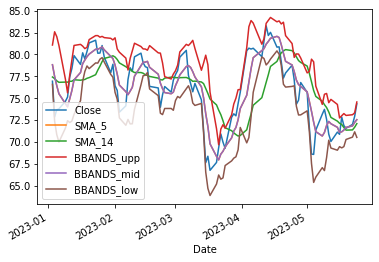

In [35]:
TA_price = ['Close', 'SMA_5', 'SMA_14', 'BBANDS_upp', 'BBANDS_mid', 'BBANDS_low']
data.pv['CL=F'][TA_price].tail(100).plot()

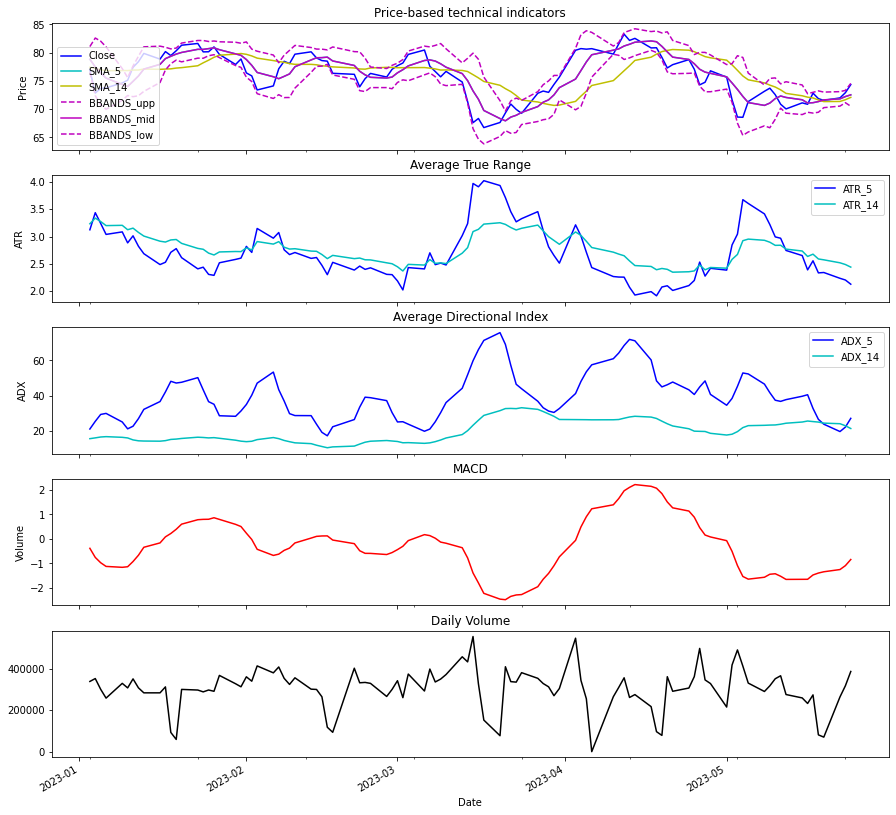

In [40]:
f, ax = plt.subplots(5,1,figsize=(15,15),sharex = True)
# plot prices
TA_prices = [['Close', 'b', '-'],\
             ['SMA_5', 'c', '-'],\
             ['SMA_14', 'y', '-'],\
             ['BBANDS_upp', 'm', '--'],\
             ['BBANDS_mid', 'm', '-'],\
             ['BBANDS_low', 'm', '--']]

ax[0].title.set_text('Price-based technical indicators')
for TA in TA_prices:
    data.pv['CL=F'][TA[0]].iloc[-100:].plot(ax=ax[0], label = TA[0],\
                                            color = TA[1], ls = TA[2])
    
ax[0].set(ylabel = 'Price')
ax[0].legend()

ax[1].title.set_text('Average True Range')
TA_ATR = [['ATR_5', 'b', '-'], ['ATR_14', 'c', '-']]
for TA in TA_ATR:
    data.pv['CL=F'][TA[0]].iloc[-100:].plot(ax=ax[1], label = TA[0],\
                                            color = TA[1], ls = TA[2])
ax[1].set(ylabel = 'ATR')
ax[1].legend()
    
ax[2].title.set_text('Average Directional Index')
TA_ADX = [['ADX_5', 'b', '-'], ['ADX_14', 'c', '-']]
for TA in TA_ADX:
    data.pv['CL=F'][TA[0]].iloc[-100:].plot(ax=ax[2], label = TA[0],\
                                            color = TA[1], ls = TA[2])
ax[2].set(ylabel = 'ADX')
ax[2].legend()

ax[3].title.set_text('MACD')
data.pv['CL=F']['MACD'].iloc[-100:].plot(ax=ax[3], label = 'MACD',\
                                        color = 'r', ls = '-')
ax[3].set(ylabel = 'MACD')


ax[4].title.set_text('Daily Volume')
data.pv['CL=F']['Volume'].iloc[-100:].plot(ax=ax[4], label = 'Volume',\
                                        color = 'k', ls = '-')
ax[3].set(ylabel = 'Volume')

plt.show()

# Apply machine learning

In [9]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
from keras.regularizers import L1, L1L2, L2
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import keras_tuner

## Extract features

Target: WTI crude oil price (Close)
Features universe: 
- set 1: Prices of other assets
- set 2: TA indicators of WTI
- set 3: Prices of other assets, TA indicators of WTI
- set 4: Other data

In [10]:
set1 = ["SPY", "^VIX", "GC=F", "BZ=F", "CL=F"]
set2 = ['Close', 'Volume', 'SMA_5', 'SMA_14', 'ATR_5', 'ATR_14', 'ADX_5', 'ADX_14', 'RSI_5',
       'RSI_14', 'MACD', 'MACD_signal', 'BBANDS_upp', 'BBANDS_mid', 'BBANDS_low']
set3 = set1 + set2

In [11]:
target_ticker = "CL=F"
Y1 = np.array(data.lp[target_ticker]).reshape(-1,1)
X1 = np.array(data.lp.drop(target_ticker, axis = 1))
Y2 = np.array(data.pv['CL=F']['Close']).reshape(-1,1)
X2 = np.array(data.pv['CL=F'][set2])


In [12]:
class LSTM_predictor:
    """
    LSTM_predictor class for predicting asset prices using LSTM model.
    """
    def __init__(self, X, Y):
        """
        Initialize the LSTM_predictor object.

        Parameters:
        - X: Input features (numpy array)
        - Y: Target variable (numpy array)
        """

        self.X, self.Y = self.__clean_data__(X, Y)
        self.features_size = X.shape[1]
        self.obs_size = X.shape[0]
        
        
    def __clean_data__(self, X, Y):
        """
        Clean the data by removing rows with NaN values.

        Parameters:
        - X: Input features (numpy array)
        - Y: Target variable (numpy array)

        Returns:
        - Cleaned X and Y (numpy arrays)
        """

        Z = np.concatenate((X, Y), axis = 1)
        Z = Z[~np.isnan(Z).any(axis=1), :]
        return Z[:, :-1], Z[:, -1]
        
    def prepare_data(self, train_test_split = 0.8, timestep = 3, look_forward = 1, inplace = False, scaled = True):
        """
        Prepare the data for training and testing.

        Parameters:
        - train_test_split: Ratio of train set to the entire dataset (float, default=0.8)
        - timestep: Number of timesteps to consider (int, default=3)
        - look_forward: Number of timesteps to look forward (int, default=1)
        - inplace: Flag indicating whether to store the prepared data in the object (bool, default=False)
        - scaled: Flag indicating whether to scale the data (bool, default=True)

        Returns:
        - List of tuples containing train and test datasets if inplace=False, None otherwise.
        """
        
        split_idx = int(self.obs_size*0.8)
        train_set = self.X[:split_idx,:], self.Y[:split_idx]
        test_set = self.X[split_idx:,:], self.Y[split_idx:]
        
        # Scale factors
        mean_X = np.mean(train_set[0], axis = 0)
        std_X = np.std(train_set[0], axis = 0)
        self.__scale_X__ = (mean_X, std_X)
        
        mean_Y = np.mean(train_set[1], axis = 0)
        std_Y = np.std(train_set[1], axis = 0)
        self.__scale_Y__ = (mean_Y, std_Y)
        
        sampled = []
        
        for X, Y in [train_set, test_set]:
            X_sampled, Y_sampled = [], []

            for i in range(len(X)-timestep-look_forward+1):
                X_sampled.append((X[i:i+timestep] - self.__scale_X__[0])/self.__scale_X__[1])
                Y_sampled.append((Y[i+timestep+look_forward-1] - self.__scale_Y__[0])/self.__scale_Y__[1])
            
            sampled.append((np.array(X_sampled),np.array(Y_sampled)))
        
        if inplace:
            self.X_train, self.Y_train = sampled[0]
            self.X_test, self.Y_test = sampled[1]
            
            return None
        else:
            return sampled
        
    def init_model(self, optimizer='adam', loss='mean_squared_error',\
                   kernel_regularizer=None,\
                   num_lstm_units_1 = 128, activation_1 = "tanh",\
                   num_lstm_units_2 = 64, activation_2 = "relu",\
                   num_dense_units = 25, learning_rate=0.005):
        
        """"
        Initialize the LSTM model.

        Args:
            optimizer (str): The optimizer for the model.
            loss (str): The loss function for the model.
            kernel_regularizer: The regularization for the LSTM kernel.
            num_lstm_units_1 (int): The number of units in the first LSTM layer.
            activation_1 (str): The activation function for the first LSTM layer.
            num_lstm_units_2 (int): The number of units in the second LSTM layer.
            activation_2 (str): The activation function for the second LSTM layer.
            num_dense_units (int): The number of units in the dense layer.
            learning_rate (float): The learning rate for the optimizer.

        Returns:
            None

        """
        
        reset_seeds() 
        model = Sequential()
        model.add(LSTM(num_lstm_units_1, return_sequences=True,\
                       input_shape= (self.X_train.shape[1], self.features_size),\
                       activation = activation_1,\
                       kernel_regularizer=kernel_regularizer))
        model.add(LSTM(num_lstm_units_2,\
                       return_sequences=False,\
                       kernel_regularizer=kernel_regularizer,\
                       activation = activation_2))
        model.add(Dense(num_dense_units))
        model.add(Dense(1))
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        model.compile(optimizer = optimizer, loss = loss)
        self.model = model
        
        return None
    
    def cross_validation(self, n_splits = 5, batch_size=100, epochs=50, callback=True):
        """
        Perform cross-validation for the LSTM model.

        Parameters:
        - n_splits: Number of cross-validation splits (int, default=5)
        - batch_size: Number of samples per gradient update (int, default=100)
        - epochs: Number of epochs to train the model (int, default=50)
        - callback: Flag indicating whether to use custom callback during training (bool, default=True)

        Returns:
        - None
        """
        reset_seeds()
        tscv = TimeSeriesSplit(n_splits=5)
        
        cv_train_scores = []
        cv_val_scores = []
        
        print('Initiate cross-validation')
        i = 1

        for train_index, test_index in tscv.split(self.X_train):
            print(f'Running cross validation round {i}')
            self.temp_val_scores = []
            cv_X_train, cv_X_test = self.X_train[train_index], self.X_train[test_index]
            cv_y_train, cv_y_test = self.Y_train[train_index], self.Y_train[test_index]
    
            # Fit your model on the training data
            history_train = self.model.fit(cv_X_train, cv_y_train, batch_size=batch_size,\
                                           epochs=epochs,\
                                           callbacks = [CustomCallback(self,cv_X_test, cv_y_test, cv = True)],
                                          verbose = 2)
            cv_train_scores.append(history_train.history['loss'])
            cv_val_scores.append(self.temp_val_scores)
            print('==============================================')
            i+=1
            
        self.cv_train_scores = np.array(cv_train_scores).mean(axis = 0)
        self.cv_val_scores = np.array(cv_val_scores).mean(axis = 0)
        
    
    def fit_model(self, batch_size=100, epochs=50, callbacks=None):
        """
        Fit the LSTM model on the training data.

        Args:
            batch_size (int): The batch size for training.
            epochs (int): The number of epochs to train the model.
            callbacks (list): List of callbacks for model training.

        Returns:
            None

        """
        self.test_loss_list = []
        self.pred_per_epoch = []
        history_train = self.model.fit(self.X_train, self.Y_train, epochs=epochs,\
                                       batch_size=batch_size, verbose=1, callbacks = callbacks)
        self.train_loss_list = history_train.history['loss']  # Store loss values in the list 
        
        
    def predict(self):
        
        self.Y_pred = self.model.predict(self.X_test)

        
    def plot_prediction(self, epoch = None):
        """
        Plot the predicted and actual values.

        Args:
            epoch (int): The epoch number to plot the predictions for. If None, use the final predictions.

        Returns:
            None

        """
        if epoch == None:
            Y_pred = self.Y_pred
        else:
            Y_pred = self.pred_per_epoch[epoch - 1]
        actual = np.concatenate((self.Y_train.reshape(-1,1), self.Y_test.reshape(-1,1)))
        actual = actual*self.__scale_Y__[1] + self.__scale_Y__[0]
        prediction = np.concatenate((self.Y_train.reshape(-1,1), Y_pred))
        prediction = prediction*self.__scale_Y__[1] + self.__scale_Y__[0]
        
        f, ax = plt.subplots(figsize=(12,5))
        plt.plot(prediction, label = 'Predicted')
        plt.plot(actual, label = 'Actual')
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def key_metrics(self, epoch = None):
        """
        Calculate key evaluation metrics for the predictions.

        Args:
            epoch (int): The epoch number to calculate metrics for. If None, use the final predictions.

        Returns:
            None

        """
        Y_pred = self.Y_pred if epoch == None else self.pred_per_epoch[epoch - 1]
        mse = mean_squared_error(self.Y_test, Y_pred)
        mae = mean_absolute_error(self.Y_test, Y_pred)
        exp_ratio = explained_variance_score(self.Y_test, Y_pred)
        
        print(f'MSE: {mse}\nMAE: {mae}\nExplained ratio: {exp_ratio}')

    def __build_model__(self,hp):
        """
        Build the LSTM model for hyperparameter tuning.

        Args:
            hp: Hyperparameters object.

        Returns:
            model: The built LSTM model.

        """

        model = Sequential()
        
        reg = self.__reg_wrapper__(hp.Choice('reg_type', ['l1', 'l2', 'none']),\
                                   hp.Choice('reg_value', [0.01, 0.05, 0.1]))
        
        model.add(LSTM(
            units=hp.Int(f"units_1", min_value=32, max_value=192, step=32),
            kernel_regularizer=reg,
            return_sequences=True,
            activation="tanh"))
        
        model.add(LSTM(
            units=32,
            kernel_regularizer=reg,
            return_sequences=True,
            activation=hp.Choice(f"activation_2", ["relu", "tanh"])))

        model.add(Dense(25))
        model.add(Dense(1))    

        learning_rate = hp.Choice('lr', [0.005, 0.01, 0.05, 0.1])
        model.compile(
            optimizer=self.__optimizer_wrapper__(hp.Choice('opt_type', ['adam', 'SGD']), learning_rate),
            loss='mean_squared_error',
            metrics = ['mean_squared_error']
        )
        return model

    def __reg_wrapper__(self, reg_type, value):
        """
        Wrap the regularization type and value.

        Args:
            reg_type (str): The type of regularization.
            reg_value (float): The regularization value.

        Returns:
            reg: The wrapped regularization.

        """
        if reg_type == 'l2':
            return L2(value)
        elif reg_type == 'l1':
            return L1(value)
        elif reg_type == 'none':
            return None

    def __optimizer_wrapper__(self, opt_type, value):
        """
        Wrapper function to create an optimizer object based on the specified optimizer type.

        Parameters:
        - opt_type: Optimizer type (str)
        - value: Learning rate or other optimizer-specific value

        Returns:
        - Optimizer object

        Raises:
        - ValueError: If the specified optimizer type is not supported
        """
        if opt_type == 'adam':
            return Adam(value)
        elif opt_type == 'SGD':
            return SGD(value)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
            
    def hyperparameter_tuner(self, max_trials = 5, executions_per_trial = 2, overwrite = True):
        """
        Perform hyperparameter tuning for the LSTM model.

        Args:
            epochs (int): The number of epochs to train the models for during hyperparameter tuning.
            max_trials (int): The maximum number of hyperparameter configurations to try.
            directory (str): The directory to store the tuning results.

        Returns:
            tuner: The trained KerasTuner tuner object.

        """
        tuner = keras_tuner.RandomSearch(
            hypermodel=self.__build_model__,
            objective="val_mean_squared_error",
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            overwrite=overwrite)
        self.tuning_results = tuner

        x_train, x_val, y_train, y_val = train_test_split(self.X_train, self.Y_train, shuffle = False, test_size=0.33)

        tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
    
class CustomCallback(keras.callbacks.Callback):
    """
    CustomCallback class for defining custom callbacks during model training.
    """
    def __init__(self, model_class, X_test = np.empty(0), Y_test = np.empty(0), cv = False):
        """
        Initialize the CustomCallback object.

        Parameters:
        - model_class: Instance of the LSTM_predictor class
        - X_test: Test input features (numpy array, default=np.empty(0))
        - Y_test: Test target variable (numpy array, default=np.empty(0))
        - cv: Flag indicating whether it is a cross-validation callback (bool, default=False)
        """
        self.mega_class = model_class
        self.model = model_class.model
        self.X_test = X_test if X_test.any() else model_class.X_test
        self.Y_test = Y_test if Y_test.any() else model_class.Y_test
        self.cv = cv

    def on_epoch_end(self, epoch, logs={}):
        """
        Callback function called at the end of each epoch during model training.

        Parameters:
        - epoch: Current epoch number (int)
        - logs: Dictionary of logs and metrics (dict)
        """
        self.Y_pred = self.model.predict(self.X_test, verbose = 0)
        mse = mean_squared_error(self.Y_test, self.Y_pred)
        if self.cv:
            self.mega_class.temp_val_scores.append(mse)
        else:
            self.mega_class.test_loss_list.append(mse)
            self.mega_class.pred_per_epoch.append(self.Y_pred)

## Model 1: LSTM crude oil price prediction using other assets' price movement

### Fit an unoptimized model

In [13]:
model1 = LSTM_predictor(X1, Y1)
model1.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1.init_model(optimizer='adam', loss='mean_squared_error')
model1.cross_validation()

Initiate cross-validation
Running cross validation round 1
Epoch 1/50
4/4 - 5s - loss: 1.5168 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 0s - loss: 0.2690 - 394ms/epoch - 98ms/step
Epoch 3/50
4/4 - 0s - loss: 0.1383 - 380ms/epoch - 95ms/step
Epoch 4/50
4/4 - 0s - loss: 0.1060 - 381ms/epoch - 95ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0745 - 429ms/epoch - 107ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0548 - 380ms/epoch - 95ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0546 - 374ms/epoch - 93ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0500 - 378ms/epoch - 95ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0438 - 460ms/epoch - 115ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0439 - 379ms/epoch - 95ms/step
Epoch 11/50
4/4 - 1s - loss: 0.0396 - 589ms/epoch - 147ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0393 - 389ms/epoch - 97ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0384 - 387ms/epoch - 97ms/step
Epoch 14/50
4/4 - 1s - loss: 0.0366 - 556ms/epoch - 139ms/step
Epoch 15/50
4/4 - 0s - loss: 0.0373 - 379ms/epoch - 95ms/step
Epoch 16/50
4/4 - 0s 

11/11 - 1s - loss: 0.0096 - 988ms/epoch - 90ms/step
Epoch 30/50
11/11 - 1s - loss: 0.0099 - 745ms/epoch - 68ms/step
Epoch 31/50
11/11 - 1s - loss: 0.0097 - 1s/epoch - 100ms/step
Epoch 32/50
11/11 - 1s - loss: 0.0097 - 1s/epoch - 105ms/step
Epoch 33/50
11/11 - 1s - loss: 0.0093 - 1s/epoch - 117ms/step
Epoch 34/50
11/11 - 1s - loss: 0.0090 - 1s/epoch - 118ms/step
Epoch 35/50
11/11 - 1s - loss: 0.0088 - 1s/epoch - 95ms/step
Epoch 36/50
11/11 - 1s - loss: 0.0091 - 1s/epoch - 120ms/step
Epoch 37/50
11/11 - 2s - loss: 0.0099 - 2s/epoch - 156ms/step
Epoch 38/50
11/11 - 1s - loss: 0.0090 - 1s/epoch - 98ms/step
Epoch 39/50
11/11 - 1s - loss: 0.0087 - 1s/epoch - 111ms/step
Epoch 40/50
11/11 - 1s - loss: 0.0083 - 1s/epoch - 92ms/step
Epoch 41/50
11/11 - 1s - loss: 0.0083 - 767ms/epoch - 70ms/step
Epoch 42/50
11/11 - 1s - loss: 0.0080 - 1s/epoch - 100ms/step
Epoch 43/50
11/11 - 1s - loss: 0.0084 - 770ms/epoch - 70ms/step
Epoch 44/50
11/11 - 1s - loss: 0.0086 - 879ms/epoch - 80ms/step
Epoch 45/50
1

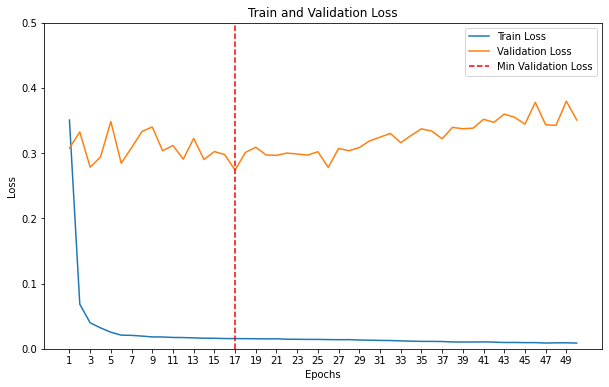

In [14]:
# Access train loss values
train_loss_values = model1.cv_train_scores

# Access validation loss values
val_loss_values = model1.cv_val_scores

min_val_loss = np.argmin(val_loss_values)+1


plt.figure(figsize=(10, 6))
# Create a plot of train and test loss
plt.plot(np.arange(1,51), train_loss_values, label='Train Loss')
plt.plot(np.arange(1,51), val_loss_values, label='Validation Loss')
plt.axvline(x = min_val_loss, ls = '--', c = 'r', label = 'Min Validation Loss')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')

plt.ylim(0,0.5)
plt.xticks(np.arange(1,51,2))

# Add legend
plt.legend()

# Show the plot
plt.show()

In [15]:
val_loss_values.min()

0.2740870561262603

Epoch 1/17
21/21 [==============================] - 1s 58ms/step - loss: 0.0232
Epoch 2/17
21/21 [==============================] - 1s 60ms/step - loss: 0.0123
Epoch 3/17
21/21 [==============================] - 1s 58ms/step - loss: 0.0091
Epoch 4/17
21/21 [==============================] - 1s 58ms/step - loss: 0.0113
Epoch 5/17
21/21 [==============================] - 2s 85ms/step - loss: 0.0089
Epoch 6/17
21/21 [==============================] - 1s 69ms/step - loss: 0.0082
Epoch 7/17
21/21 [==============================] - 2s 81ms/step - loss: 0.0082
Epoch 8/17
21/21 [==============================] - 2s 82ms/step - loss: 0.0085
Epoch 9/17
21/21 [==============================] - 2s 97ms/step - loss: 0.0079
Epoch 10/17
21/21 [==============================] - 1s 62ms/step - loss: 0.0088
Epoch 11/17
21/21 [==============================] - 1s 60ms/step - loss: 0.0084
Epoch 12/17
21/21 [==============================] - 2s 80ms/step - loss: 0.0081
Epoch 13/17
21/21 [==================

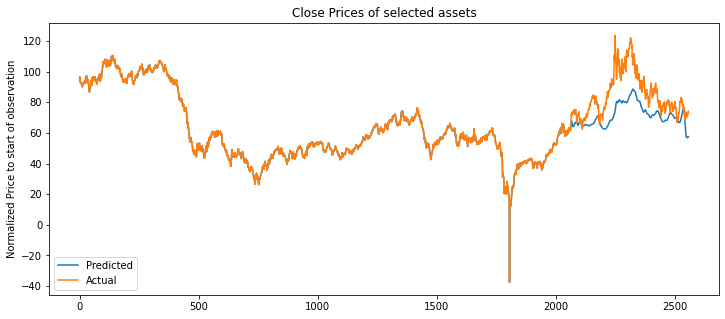

MSE: 0.5429594621684122
MAE: 0.6160218630874579
Explained ratio: 0.5686626941324748


In [16]:
model1.fit_model(epochs=min_val_loss,batch_size=100)
model1.predict()
model1.plot_prediction()
model1.key_metrics()

### Conduct hyperparamter tuning using Keras-Tuner

In [17]:
model1.hyperparameter_tuner(max_trials = 10, executions_per_trial = 5)

Trial 10 Complete [00h 09m 12s]
val_mean_squared_error: 0.6355080723762512

Best val_mean_squared_error So Far: 0.39092687964439393
Total elapsed time: 00h 54m 45s
INFO:tensorflow:Oracle triggered exit


In [18]:
model1.tuning_results.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 05 summary
Hyperparameters:
reg_type: none
reg_value: 0.05
units_1: 96
activation_2: relu
lr: 0.1
opt_type: SGD
Score: 0.39092687964439393

Trial 01 summary
Hyperparameters:
reg_type: none
reg_value: 0.01
units_1: 96
activation_2: tanh
lr: 0.1
opt_type: SGD
Score: 0.4388514518737793

Trial 03 summary
Hyperparameters:
reg_type: none
reg_value: 0.1
units_1: 192
activation_2: tanh
lr: 0.05
opt_type: SGD
Score: 0.5371540069580079

Trial 07 summary
Hyperparameters:
reg_type: none
reg_value: 0.01
units_1: 96
activation_2: relu
lr: 0.005
opt_type: SGD
Score: 0.6067607164382934

Trial 09 summary
Hyperparameters:
reg_type: none
reg_value: 0.1
units_1: 160
activation_2: tanh
lr: 0.01
opt_type: SGD
Score: 0.6355080723762512

Trial 02 summary
Hyperparameters:
reg_type: l1
reg_value: 0.01
units_1: 64
activation_2: tanh
lr: 0.01
opt_type: adam
Score: 0.701960909366607

In [20]:
m1_optimized_params = {
    'optimizer':'SGD',\
    'kernel_regularizer': None,\
    'num_lstm_units_1': 96,\
    'activation_2': 'relu',\
    'learning_rate': 0.1
}

model1_tuned = LSTM_predictor(X1, Y1)
model1_tuned.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1_tuned.init_model(**m1_optimized_params)
model1_tuned.cross_validation()

Initiate cross-validation
Running cross validation round 1
Epoch 1/50
4/4 - 10s - loss: 1.8075 - 10s/epoch - 2s/step
Epoch 2/50
4/4 - 5s - loss: 0.2596 - 5s/epoch - 1s/step
Epoch 3/50
4/4 - 5s - loss: 0.0602 - 5s/epoch - 1s/step
Epoch 4/50
4/4 - 5s - loss: 0.0546 - 5s/epoch - 1s/step
Epoch 5/50
4/4 - 5s - loss: 0.0525 - 5s/epoch - 1s/step
Epoch 6/50
4/4 - 6s - loss: 0.0505 - 6s/epoch - 1s/step
Epoch 7/50
4/4 - 5s - loss: 0.0494 - 5s/epoch - 1s/step
Epoch 8/50
4/4 - 5s - loss: 0.0473 - 5s/epoch - 1s/step
Epoch 9/50
4/4 - 5s - loss: 0.0461 - 5s/epoch - 1s/step
Epoch 10/50
4/4 - 5s - loss: 0.0453 - 5s/epoch - 1s/step
Epoch 11/50
4/4 - 5s - loss: 0.0443 - 5s/epoch - 1s/step
Epoch 12/50
4/4 - 4s - loss: 0.0436 - 4s/epoch - 1s/step
Epoch 13/50
4/4 - 5s - loss: 0.0426 - 5s/epoch - 1s/step
Epoch 14/50
4/4 - 4s - loss: 0.0425 - 4s/epoch - 1s/step
Epoch 15/50
4/4 - 4s - loss: 0.0417 - 4s/epoch - 1s/step
Epoch 16/50
4/4 - 4s - loss: 0.0411 - 4s/epoch - 1s/step
Epoch 17/50
4/4 - 4s - loss: 0.0419 

Epoch 39/50
11/11 - 12s - loss: 0.0238 - 12s/epoch - 1s/step
Epoch 40/50
11/11 - 12s - loss: 0.0239 - 12s/epoch - 1s/step
Epoch 41/50
11/11 - 12s - loss: 0.0238 - 12s/epoch - 1s/step
Epoch 42/50
11/11 - 13s - loss: 0.0237 - 13s/epoch - 1s/step
Epoch 43/50
11/11 - 12s - loss: 0.0237 - 12s/epoch - 1s/step
Epoch 44/50
11/11 - 11s - loss: 0.0235 - 11s/epoch - 1s/step
Epoch 45/50
11/11 - 11s - loss: 0.0235 - 11s/epoch - 973ms/step
Epoch 46/50
11/11 - 11s - loss: 0.0236 - 11s/epoch - 1s/step
Epoch 47/50
11/11 - 13s - loss: 0.0233 - 13s/epoch - 1s/step
Epoch 48/50
11/11 - 12s - loss: 0.0232 - 12s/epoch - 1s/step
Epoch 49/50
11/11 - 12s - loss: 0.0233 - 12s/epoch - 1s/step
Epoch 50/50
11/11 - 11s - loss: 0.0232 - 11s/epoch - 1s/step
Running cross validation round 4
Epoch 1/50
14/14 - 15s - loss: 0.0286 - 15s/epoch - 1s/step
Epoch 2/50
14/14 - 15s - loss: 0.0268 - 15s/epoch - 1s/step
Epoch 3/50
14/14 - 14s - loss: 0.0255 - 14s/epoch - 993ms/step
Epoch 4/50
14/14 - 15s - loss: 0.0245 - 15s/epoch

Epoch 1/13
21/21 [==============================] - 17s 796ms/step - loss: 0.0608
Epoch 2/13
21/21 [==============================] - 17s 823ms/step - loss: 0.0419
Epoch 3/13
21/21 [==============================] - 18s 858ms/step - loss: 0.0352
Epoch 4/13
21/21 [==============================] - 18s 846ms/step - loss: 0.0319
Epoch 5/13
21/21 [==============================] - 17s 786ms/step - loss: 0.0298
Epoch 6/13
21/21 [==============================] - 17s 800ms/step - loss: 0.0285
Epoch 7/13
21/21 [==============================] - 17s 791ms/step - loss: 0.0275
Epoch 8/13
21/21 [==============================] - 17s 791ms/step - loss: 0.0268
Epoch 9/13
21/21 [==============================] - 20s 953ms/step - loss: 0.0264
Epoch 10/13
21/21 [==============================] - 17s 828ms/step - loss: 0.0259
Epoch 11/13
21/21 [==============================] - 22s 1s/step - loss: 0.0255
Epoch 12/13
21/21 [==============================] - 21s 1s/step - loss: 0.0252
Epoch 13/13
16/16 [

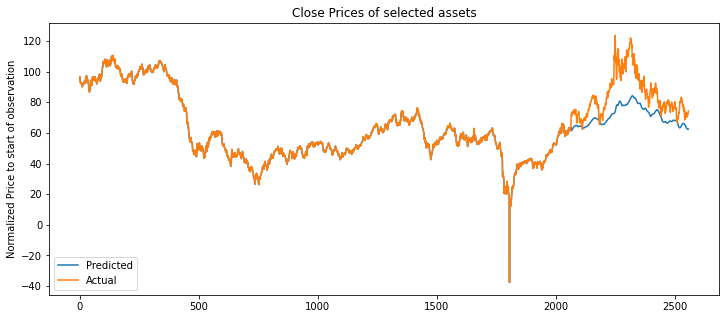

MSE: 0.5755499789251831
MAE: 0.6428173946705065
Explained ratio: 0.5813781256719327


In [24]:
opt_epoch = np.argmin(model1_tuned.cv_val_scores)+1
model1_tuned.fit_model(epochs=opt_epoch,batch_size=100)
model1_tuned.predict()
model1_tuned.plot_prediction()
model1_tuned.key_metrics()

## Model 2: Crude oil price prediction using technical indicators only

In [25]:
model2 = LSTM_predictor(X2, Y2)
model2.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model2.init_model(optimizer='adam', loss='mean_squared_error')
model2.cross_validation()

Initiate cross-validation
Running cross validation round 1
Epoch 1/50
4/4 - 7s - loss: 1.0079 - 7s/epoch - 2s/step
Epoch 2/50
4/4 - 2s - loss: 0.1640 - 2s/epoch - 387ms/step
Epoch 3/50
4/4 - 2s - loss: 0.1379 - 2s/epoch - 389ms/step
Epoch 4/50
4/4 - 2s - loss: 0.0354 - 2s/epoch - 382ms/step
Epoch 5/50
4/4 - 2s - loss: 0.0419 - 2s/epoch - 390ms/step
Epoch 6/50
4/4 - 2s - loss: 0.0261 - 2s/epoch - 381ms/step
Epoch 7/50
4/4 - 2s - loss: 0.0243 - 2s/epoch - 420ms/step
Epoch 8/50
4/4 - 2s - loss: 0.0220 - 2s/epoch - 539ms/step
Epoch 9/50
4/4 - 2s - loss: 0.0194 - 2s/epoch - 479ms/step
Epoch 10/50
4/4 - 2s - loss: 0.0188 - 2s/epoch - 474ms/step
Epoch 11/50
4/4 - 3s - loss: 0.0161 - 3s/epoch - 785ms/step
Epoch 12/50
4/4 - 2s - loss: 0.0162 - 2s/epoch - 578ms/step
Epoch 13/50
4/4 - 2s - loss: 0.0145 - 2s/epoch - 446ms/step
Epoch 14/50
4/4 - 2s - loss: 0.0144 - 2s/epoch - 437ms/step
Epoch 15/50
4/4 - 2s - loss: 0.0138 - 2s/epoch - 438ms/step
Epoch 16/50
4/4 - 2s - loss: 0.0126 - 2s/epoch - 414m

Epoch 34/50
11/11 - 8s - loss: 0.0026 - 8s/epoch - 763ms/step
Epoch 35/50
11/11 - 8s - loss: 0.0027 - 8s/epoch - 717ms/step
Epoch 36/50
11/11 - 5s - loss: 0.0028 - 5s/epoch - 493ms/step
Epoch 37/50
11/11 - 6s - loss: 0.0029 - 6s/epoch - 582ms/step
Epoch 38/50
11/11 - 5s - loss: 0.0026 - 5s/epoch - 410ms/step
Epoch 39/50
11/11 - 6s - loss: 0.0027 - 6s/epoch - 513ms/step
Epoch 40/50
11/11 - 8s - loss: 0.0029 - 8s/epoch - 700ms/step
Epoch 41/50
11/11 - 5s - loss: 0.0027 - 5s/epoch - 434ms/step
Epoch 42/50
11/11 - 4s - loss: 0.0026 - 4s/epoch - 399ms/step
Epoch 43/50
11/11 - 5s - loss: 0.0025 - 5s/epoch - 500ms/step
Epoch 44/50
11/11 - 5s - loss: 0.0024 - 5s/epoch - 423ms/step
Epoch 45/50
11/11 - 6s - loss: 0.0027 - 6s/epoch - 572ms/step
Epoch 46/50
11/11 - 6s - loss: 0.0027 - 6s/epoch - 553ms/step
Epoch 47/50
11/11 - 4s - loss: 0.0031 - 4s/epoch - 404ms/step
Epoch 48/50
11/11 - 5s - loss: 0.0025 - 5s/epoch - 496ms/step
Epoch 49/50
11/11 - 5s - loss: 0.0024 - 5s/epoch - 433ms/step
Epoch 50

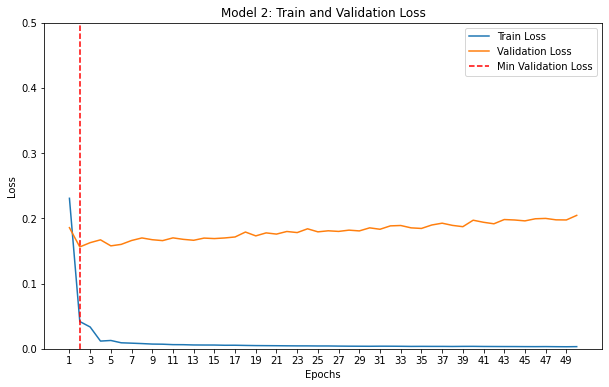

In [26]:
# Access train loss values
train_loss_values_2 = model2.cv_train_scores

# Access validation loss values
val_loss_values_2 = model2.cv_val_scores

min_val_loss_2 = np.argmin(val_loss_values_2)+1


plt.figure(figsize=(10, 6))
# Create a plot of train and test loss
plt.plot(np.arange(1,51), train_loss_values_2, label='Train Loss')
plt.plot(np.arange(1,51), val_loss_values_2, label='Validation Loss')
plt.axvline(x = min_val_loss_2, ls = '--', c = 'r', label = 'Min Validation Loss')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 2: Train and Validation Loss')

plt.ylim(0,0.5)
plt.xticks(np.arange(1,51,2))

# Add legend
plt.legend()

# Show the plot
plt.show()

Epoch 1/2
21/21 [==============================] - 6s 308ms/step - loss: 0.0234
Epoch 2/2
15/15 [==============================] - 1s 38ms/step


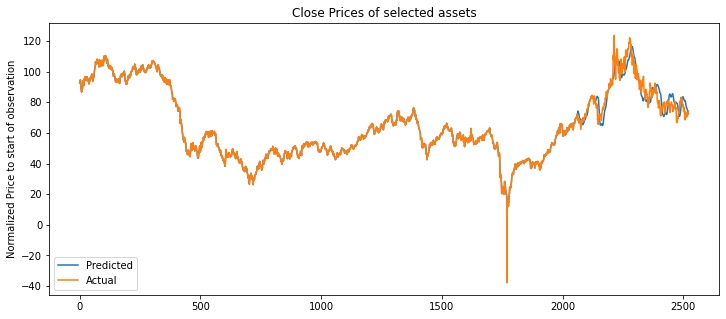

MSE: 0.09294730096069981
MAE: 0.24228444326307172
Explained ratio: 0.7749256864318617


In [27]:
model2.fit_model(epochs=min_val_loss_2,batch_size=100)
model2.predict()
model2.plot_prediction()
model2.key_metrics()

### Conduct hyperparamter tuning using Keras-Tuner

In [29]:
model2.hyperparameter_tuner(max_trials = 10, executions_per_trial = 5)

Trial 10 Complete [00h 09m 51s]
val_mean_squared_error: 0.5303717851638794

Best val_mean_squared_error So Far: 0.33226214051246644
Total elapsed time: 01h 10m 39s
INFO:tensorflow:Oracle triggered exit


In [30]:
model2.tuning_results.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 03 summary
Hyperparameters:
reg_type: none
reg_value: 0.1
units_1: 192
activation_2: tanh
lr: 0.05
opt_type: SGD
Score: 0.33226214051246644

Trial 01 summary
Hyperparameters:
reg_type: none
reg_value: 0.01
units_1: 96
activation_2: tanh
lr: 0.1
opt_type: SGD
Score: 0.35165406465530397

Trial 05 summary
Hyperparameters:
reg_type: none
reg_value: 0.05
units_1: 96
activation_2: relu
lr: 0.1
opt_type: SGD
Score: 0.3634762167930603

Trial 09 summary
Hyperparameters:
reg_type: none
reg_value: 0.1
units_1: 160
activation_2: tanh
lr: 0.01
opt_type: SGD
Score: 0.5303717851638794

Trial 02 summary
Hyperparameters:
reg_type: l1
reg_value: 0.01
units_1: 64
activation_2: tanh
lr: 0.01
opt_type: adam
Score: 0.6761592268943787

Trial 00 summary
Hyperparameters:
reg_type: l2
reg_value: 0.1
units_1: 96
activation_2: relu
lr: 0.005
opt_type: adam
Score: 0.6799790620803833

Initiate cross-validation
Running cross validation round 1
Epoch 1/50
4/4 - 10s - loss: 0.6487 - 10s/epoch - 3s/step
Epoch 2/50
4/4 - 4s - loss: 0.0276 - 4s/epoch - 944ms/step
Epoch 3/50
4/4 - 4s - loss: 0.0272 - 4s/epoch - 965ms/step
Epoch 4/50
4/4 - 5s - loss: 0.0265 - 5s/epoch - 1s/step
Epoch 5/50
4/4 - 4s - loss: 0.0264 - 4s/epoch - 1s/step
Epoch 6/50
4/4 - 5s - loss: 0.0256 - 5s/epoch - 1s/step
Epoch 7/50
4/4 - 5s - loss: 0.0250 - 5s/epoch - 1s/step
Epoch 8/50
4/4 - 5s - loss: 0.0247 - 5s/epoch - 1s/step
Epoch 9/50
4/4 - 5s - loss: 0.0243 - 5s/epoch - 1s/step
Epoch 10/50
4/4 - 5s - loss: 0.0240 - 5s/epoch - 1s/step
Epoch 11/50
4/4 - 5s - loss: 0.0235 - 5s/epoch - 1s/step
Epoch 12/50
4/4 - 4s - loss: 0.0233 - 4s/epoch - 939ms/step
Epoch 13/50
4/4 - 4s - loss: 0.0233 - 4s/epoch - 1s/step
Epoch 14/50
4/4 - 4s - loss: 0.0230 - 4s/epoch - 958ms/step
Epoch 15/50
4/4 - 4s - loss: 0.0230 - 4s/epoch - 1s/step
Epoch 16/50
4/4 - 5s - loss: 0.0222 - 5s/epoch - 1s/step
Epoch 17/50
4/4 - 5s - l

Epoch 38/50
11/11 - 11s - loss: 0.0109 - 11s/epoch - 961ms/step
Epoch 39/50
11/11 - 12s - loss: 0.0108 - 12s/epoch - 1s/step
Epoch 40/50
11/11 - 12s - loss: 0.0108 - 12s/epoch - 1s/step
Epoch 41/50
11/11 - 10s - loss: 0.0108 - 10s/epoch - 923ms/step
Epoch 42/50
11/11 - 10s - loss: 0.0108 - 10s/epoch - 880ms/step
Epoch 43/50
11/11 - 10s - loss: 0.0107 - 10s/epoch - 865ms/step
Epoch 44/50
11/11 - 13s - loss: 0.0107 - 13s/epoch - 1s/step
Epoch 45/50
11/11 - 13s - loss: 0.0107 - 13s/epoch - 1s/step
Epoch 46/50
11/11 - 13s - loss: 0.0106 - 13s/epoch - 1s/step
Epoch 47/50
11/11 - 14s - loss: 0.0105 - 14s/epoch - 1s/step
Epoch 48/50
11/11 - 16s - loss: 0.0106 - 16s/epoch - 1s/step
Epoch 49/50
11/11 - 16s - loss: 0.0104 - 16s/epoch - 1s/step
Epoch 50/50
11/11 - 16s - loss: 0.0105 - 16s/epoch - 1s/step
Running cross validation round 4
Epoch 1/50
14/14 - 20s - loss: 0.0127 - 20s/epoch - 1s/step
Epoch 2/50
14/14 - 21s - loss: 0.0120 - 21s/epoch - 1s/step
Epoch 3/50
14/14 - 18s - loss: 0.0116 - 18

21/21 [==============================] - 23s 1s/step - loss: 0.0148
Epoch 15/47
21/21 [==============================] - 33s 2s/step - loss: 0.0147
Epoch 16/47
21/21 [==============================] - 30s 1s/step - loss: 0.0146
Epoch 17/47
21/21 [==============================] - 25s 1s/step - loss: 0.0144
Epoch 18/47
21/21 [==============================] - 30s 1s/step - loss: 0.0144
Epoch 19/47
21/21 [==============================] - 29s 1s/step - loss: 0.0144
Epoch 20/47
21/21 [==============================] - 30s 1s/step - loss: 0.0143
Epoch 21/47
21/21 [==============================] - 30s 1s/step - loss: 0.0141
Epoch 22/47
21/21 [==============================] - 30s 1s/step - loss: 0.0142
Epoch 23/47
21/21 [==============================] - 35s 2s/step - loss: 0.0141
Epoch 24/47
21/21 [==============================] - 28s 1s/step - loss: 0.0140
Epoch 25/47
21/21 [==============================] - 27s 1s/step - loss: 0.0139
Epoch 26/47
21/21 [==============================] -

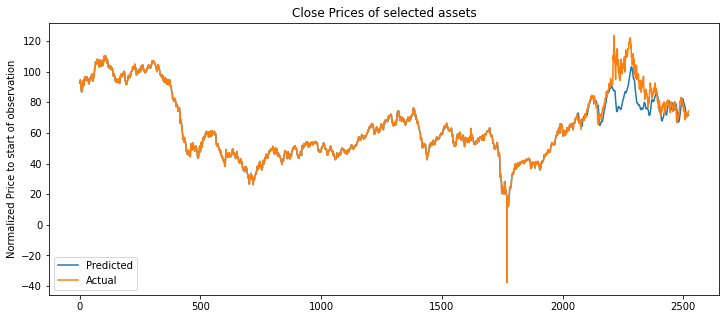

MSE: 0.31376755806777257
MAE: 0.3920512610595035
Explained ratio: 0.49724592793962785


In [31]:
m2_optimized_params = {
    'optimizer':'SGD',\
    'kernel_regularizer': None,\
    'num_lstm_units_1': 192,\
    'activation_2': 'tanh',\
    'learning_rate': 0.05
}

model2_tuned = LSTM_predictor(X2, Y2)
model2_tuned.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model2_tuned.init_model(**m2_optimized_params)
model2_tuned.cross_validation()

m2_opt_epoch = np.argmin(model2_tuned.cv_val_scores)+1
model2_tuned.fit_model(epochs=m2_opt_epoch,batch_size=100)
model2_tuned.predict()
model2_tuned.plot_prediction()
model2_tuned.key_metrics()

# References

1. A combined architecture of <b>multivariate LSTM</b> with Mahalanobis and Z-Score transformations for oil price forecasting
2. A detailed look at crude oil price volatility prediction using <b>macroeconomic variables</b>
3. Crude oil price prediction using deep reinforcement learning

# Versioning

In [ ]:
print(f'numpy: {np.__version__}\npandas: {pd.__version__}\nseaborn: {sns.__version__}\n\
yfinance: {yf.__version__}\ntalib: {talib.__version__}\ntensorflow: {tf.__version__}')
